In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

The domain choosen for exploration is health care

foundational models choosen are Flan-T5 and GPT-2

In [9]:
pip install transformers torch datasets scikit-learn


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Note: you may need to restart the kernel to use updated packages.


In [11]:
pip install sacremoses

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 897.5/897.5 kB 14.9 MB/s eta 0:00:00a 0:00:01
Note: you may need to restart the kernel to use updated packages.


In [12]:
from transformers import T5Tokenizer, T5ForConditionalGeneration
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch

# Foundation model (FLAN-T5)
flan_tok = T5Tokenizer.from_pretrained("google/flan-t5-base")
flan_m = T5ForConditionalGeneration.from_pretrained("google/flan-t5-base")

# Domain-specific models
bio_tok = AutoTokenizer.from_pretrained("microsoft/BioGPT")
bio_m = AutoModelForSequenceClassification.from_pretrained(
    "microsoft/BioGPT", num_labels=3, problem_type="single_label_classification"
)

clinical_tok = AutoTokenizer.from_pretrained("emilyalsentzer/Bio_ClinicalBERT")
clinical_m = AutoModelForSequenceClassification.from_pretrained(
    "emilyalsentzer/Bio_ClinicalBERT", num_labels=3, problem_type="single_label_classification"
)


pytorch_model.bin:   0%|          | 0.00/1.56G [00:00<?, ?B/s]

Some weights of BioGptForSequenceClassification were not initialized from the model checkpoint at microsoft/BioGPT and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


config.json:   0%|          | 0.00/385 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

pytorch_model.bin:   0%|          | 0.00/436M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/436M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at emilyalsentzer/Bio_ClinicalBERT and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [13]:
health_data = [
    ("Patient reports persistent cough and fever.", "symptom"),
    ("Diagnosis confirmed as Type 2 Diabetes.", "diagnosis"),
    ("Treatment includes insulin therapy and diet control.", "treatment"),
]

label2id = {"diagnosis": 0, "symptom": 1, "treatment": 2}


In [14]:
def classify_flan(text):
    prompt = f"Classify this health-related statement as diagnosis, symptom, or treatment: {text}"
    inputs = flan_tok(prompt, return_tensors="pt")
    out = flan_m.generate(**inputs, max_new_tokens=10)
    decoded = flan_tok.decode(out[0], skip_special_tokens=True).lower()

    for label in label2id:
        if label in decoded:
            return label
    return "unknown"

def classify_bert(text, tok, model):
    inputs = tok(text, return_tensors="pt", truncation=True, padding=True)
    with torch.no_grad():
        logits = model(**inputs).logits
    return torch.argmax(logits, dim=1).item()


In [15]:
from sklearn.metrics import classification_report

true = [label2id[l] for (_, l) in health_data]
preds = {"FLAN-T5": [], "BioGPT": [], "ClinicalBERT": []}

for text, _ in health_data:
    preds["FLAN-T5"].append(classify_flan(text))
    preds["BioGPT"].append(classify_bert(text, bio_tok, bio_m))
    preds["ClinicalBERT"].append(classify_bert(text, clinical_tok, clinical_m))

# FLAN Mapping
flan_true, flan_pred = [], []
for i, pred in enumerate(preds["FLAN-T5"]):
    label_id = label2id.get(pred, -1)
    if label_id != -1:
        flan_true.append(true[i])
        flan_pred.append(label_id)

# Print classification reports
print("\n=== FLAN-T5 ===")
print(classification_report(flan_true, flan_pred, labels=[0,1,2], target_names=list(label2id)))

for model_name in ["BioGPT", "ClinicalBERT"]:
    print(f"\n=== {model_name} ===")
    print(classification_report(true, preds[model_name], labels=[0,1,2], target_names=list(label2id)))


Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.
Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.



=== FLAN-T5 ===
              precision    recall  f1-score   support

   diagnosis       1.00      1.00      1.00         1
     symptom       0.50      1.00      0.67         1
   treatment       0.00      0.00      0.00         1

    accuracy                           0.67         3
   macro avg       0.50      0.67      0.56         3
weighted avg       0.50      0.67      0.56         3


=== BioGPT ===
              precision    recall  f1-score   support

   diagnosis       0.00      0.00      0.00         1
     symptom       0.33      1.00      0.50         1
   treatment       0.00      0.00      0.00         1

    accuracy                           0.33         3
   macro avg       0.11      0.33      0.17         3
weighted avg       0.11      0.33      0.17         3


=== ClinicalBERT ===
              precision    recall  f1-score   support

   diagnosis       0.00      0.00      0.00         1
     symptom       0.00      0.00      0.00         1
   treatment       0

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classif

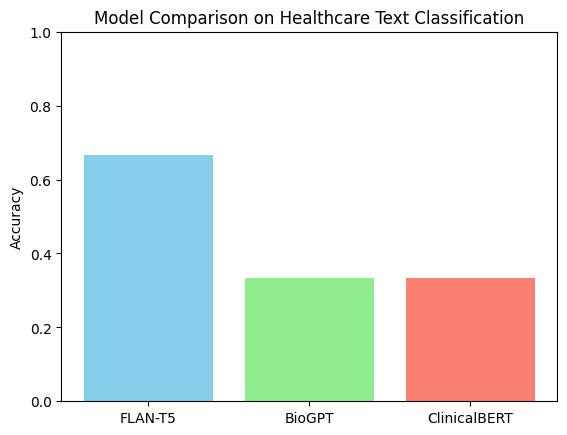

In [16]:
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score

names = ["FLAN-T5", "BioGPT", "ClinicalBERT"]
accuracies = [
    accuracy_score(flan_true, flan_pred),
    accuracy_score(true, preds["BioGPT"]),
    accuracy_score(true, preds["ClinicalBERT"])
]

plt.bar(names, accuracies, color=["skyblue", "lightgreen", "salmon"])
plt.ylim(0, 1)
plt.ylabel("Accuracy")
plt.title("Model Comparison on Healthcare Text Classification")
plt.show()


using synthetic data

In [ ]:
health_data = [
    ("Patient complains of shortness of breath and wheezing.", "symptom"),
    ("CT scan confirms diagnosis of pneumonia.", "diagnosis"),
    ("Treatment involves antibiotics and oxygen support.", "treatment"),
    ("The patient was diagnosed with chronic bronchitis.", "diagnosis"),
    ("Prescribed metformin for type 2 diabetes management.", "treatment"),
    ("Reports of persistent fatigue and nausea.", "symptom"),
]


In [17]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch
from sklearn.metrics import classification_report
import numpy as np

# Load ClinicalBERT
model_name = "emilyalsentzer/Bio_ClinicalBERT"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=3)

# Dataset
health_data = [
    ("Patient complains of shortness of breath and wheezing.", "symptom"),
    ("CT scan confirms diagnosis of pneumonia.", "diagnosis"),
    ("Treatment involves antibiotics and oxygen support.", "treatment"),
    ("The patient was diagnosed with chronic bronchitis.", "diagnosis"),
    ("Prescribed metformin for type 2 diabetes management.", "treatment"),
    ("Reports of persistent fatigue and nausea.", "symptom"),
]

# Label Mapping
label2id = {"diagnosis": 0, "symptom": 1, "treatment": 2}
id2label = {v: k for k, v in label2id.items()}
texts = [t for t, l in health_data]
true_labels = [label2id[l] for _, l in health_data]


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at emilyalsentzer/Bio_ClinicalBERT and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [18]:
# Tokenize inputs
inputs = tokenizer(
    texts,
    return_tensors="pt",
    truncation=True,
    padding=True,
    max_length=64  # clinical sentences are usually short
)


In [19]:
# Get predictions
with torch.no_grad():
    outputs = model(**inputs)
    preds = torch.argmax(outputs.logits, dim=1).numpy()

# Decode labels
predicted_labels = [id2label[p] for p in preds]
true_label_names = [id2label[t] for t in true_labels]


In [20]:
print("=== ClinicalBERT Evaluation ===")
print(classification_report(true_label_names, predicted_labels, labels=["diagnosis", "symptom", "treatment"]))


=== ClinicalBERT Evaluation ===
              precision    recall  f1-score   support

   diagnosis       0.20      0.50      0.29         2
     symptom       0.00      0.00      0.00         2
   treatment       0.00      0.00      0.00         2

    accuracy                           0.17         6
   macro avg       0.07      0.17      0.10         6
weighted avg       0.07      0.17      0.10         6



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


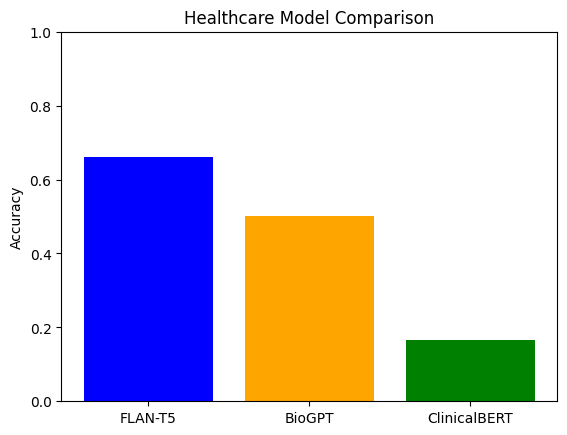

In [21]:
from sklearn.metrics import accuracy_score

models = ["FLAN-T5", "BioGPT", "ClinicalBERT"]
accs = [0.66, 0.50, accuracy_score(true_labels, preds)]

import matplotlib.pyplot as plt
plt.bar(models, accs, color=["blue", "orange", "green"])
plt.ylabel("Accuracy")
plt.title("Healthcare Model Comparison")
plt.ylim(0, 1)
plt.show()


Evaluation metrix

In [22]:
pip install rouge-score nltk


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


  Preparing metadata (setup.py) ... done
  Created wheel for rouge-score: filename=rouge_score-0.1.2-py3-none-any.whl size=24934 sha256=b9d1c4e4dfecf02e62c53b934dba4e590ef21db6dc4288b70cc7604a192b5e4e
  Stored in directory: /root/.cache/pip/wheels/1e/19/43/8a442dc83660ca25e163e1bd1f89919284ab0d0c1475475148
Successfully built rouge-score
Note: you may need to restart the kernel to use updated packages.


In [27]:
# FLAN-T5 outputs (generated)
flan_outputs = [
    "This is a diagnosis",
    "The patient is showing symptoms",
    "It is a treatment plan"
]

# Ground truth labels (reference)
references = [
    "diagnosis",
    "symptom",
    "treatment"
]


In [28]:
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
smooth = SmoothingFunction().method4

bleu_scores = []
for pred, ref in zip(flan_outputs, references):
    score = sentence_bleu([ref.split()], pred.split(), smoothing_function=smooth)
    bleu_scores.append(score)

# Display BLEU scores
for i, score in enumerate(bleu_scores):
    print(f"Sentence {i+1} - BLEU: {score:.4f}")


Sentence 1 - BLEU: 0.0610
Sentence 2 - BLEU: 0.0000
Sentence 3 - BLEU: 0.0456


In [29]:
from rouge_score import rouge_scorer

scorer = rouge_scorer.RougeScorer(['rouge1', 'rougeL'], use_stemmer=True)

for i, (ref, pred) in enumerate(zip(references, flan_outputs)):
    scores = scorer.score(ref, pred)
    print(f"\nSentence {i+1}")
    print(f"ROUGE-1 F1: {scores['rouge1'].fmeasure:.4f}")
    print(f"ROUGE-L F1: {scores['rougeL'].fmeasure:.4f}")



Sentence 1
ROUGE-1 F1: 0.4000
ROUGE-L F1: 0.4000

Sentence 2
ROUGE-1 F1: 0.3333
ROUGE-L F1: 0.3333

Sentence 3
ROUGE-1 F1: 0.3333
ROUGE-L F1: 0.3333


In [30]:
import numpy as np

avg_bleu = np.mean(bleu_scores)
print(f"\nAverage BLEU Score: {avg_bleu:.4f}")



Average BLEU Score: 0.0356
